**Note**: This notebook loads in some data from the fMRI dataset collected by Chen et al. (2017).  If you want to download that data to run this notebook, run the script at `code/helpers/download_neural_data.sh`.

## Import libraries

In [1]:
import sys
import numpy as np
import pandas as pd
from os.path import abspath, join as opj
from fastdtw import fastdtw
from nilearn.datasets import fetch_surf_fsaverage 
from nilearn.image import load_img, new_img_like
from nilearn.plotting import plot_surf_stat_map
from nilearn.surface import vol_to_surf
from scipy.spatial.distance import cdist, correlation

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import analysis helpers

In [2]:
sys.path.insert(0, abspath('../../helpers/'))
from analysis_helpers import create_diag_mask, warp_recall

Functions and variables used across multiple notebooks can be found [here](https://github.com/contextlab/sherlock-topic-model-paper/blob/master/code/helpers/analysis_helpers.py)

## Set paths & parameters

In [3]:
datadir = '../../../data/processed/'
figdir = '../../../paper/figs/'
sl_vdir = opj(datadir, 'searchlight_video')
sl_rdir = opj(datadir, 'searchlight_recall')

# example voxel
sl_rad = 2
ex_x, ex_y, ex_z, ex_sub = (50, 57, 25, 4)

sns.set_context('paper')
mpl.rcParams['pdf.fonttype'] = 42
corrmat_cmap = plt.cm.bone_r
brain_cmap = plt.cm.hot

## Define functions

In [4]:
def draw_colorbar(colorbar_ax, cmap, vmin=-1, vmax=1, tick_freq=.2, 
                  offset=0, orientation='vertical', hide_ticks=False, 
                  ticklocation='auto', tick_color='k', tick_width=None, 
                  ticklabel_size=10, n_decimals=2, **cbar_kwargs):
    # draws a shared colorbar for a figure with nilearn subplots
    ticks = np.arange(vmin, vmax + tick_freq, tick_freq).round(decimals=2)
    bounds = np.linspace(vmin, vmax, cmap.N)
    norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)
    # some colormap hacking
    cmaplist = [cmap(i) for i in range(cmap.N)]
    istart = int(norm(-offset, clip=True) * (cmap.N - 1))
    istop = int(norm(offset, clip=True) * (cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

    ColorbarBase(
        colorbar_ax, cmap=cmap, ticks=ticks, norm=norm,
        orientation=orientation, ticklocation=ticklocation, boundaries=bounds,
        spacing='proportional', format='%.2g', **cbar_kwargs)
    
    if orientation == 'vertical':
        cba = colorbar_ax.yaxis
        if ticklocation in ['auto', 'left']:
            cba.tick_left()
        else:
            cba.tick_right()
    else:
        cba = colorbar_ax.xaxis
        if ticklocation == 'bottom':
            cba.tick_bottom()
        else:
            cba.tick_top()

    for tick in cba.get_ticklabels():
        tick.set_color(tick_color)
        tick.set_size(ticklabel_size)
        
    if hide_ticks:
        cba.set_tick_params(width=0)
    elif tick_width is not None:
        cba.set_tick_params(width=tick_width)

## Load data

In [5]:
# video and example participant trajectories
video, recalls = np.load(opj(datadir, 'models_t100_v50_r10.npy'), allow_pickle=True)
p17_recall = recalls[-1]

# MNI-space reference image
ref_img = load_img(opj(datadir, 'searchlight_video', 'ref_img.nii.gz'))

# surface textures for plotting
fsaverage = fetch_surf_fsaverage(mesh='fsaverage5')
vid_surface_left = np.load(opj(sl_vdir, 'video_surface_left.npy'))
vid_surface_right = np.load(opj(sl_vdir, 'video_surface_right.npy'))
rec_surface_left = np.load(opj(sl_rdir, 'recall_surface_left.npy'))
rec_surface_right = np.load(opj(sl_rdir, 'recall_surface_right.npy'))

# p-value maps from neurosynth decoding
ns_vmap = load_img(opj(sl_vdir, 'ns_map_video.nii.gz'))
ns_rmap = load_img(opj(sl_rdir, 'ns_map_recall.nii.gz'))

In [6]:
# example searchlight
ex_scan = load_img(opj(datadir, 'fMRI', f'sherlock_movie_s{ex_sub}.nii.gz')).dataobj
ex_searchlight = ex_scan[
    ex_x - sl_rad : ex_x + sl_rad + 1, 
    ex_y - sl_rad : ex_y + sl_rad + 1, 
    ex_z - sl_rad : ex_z + sl_rad + 1
]

# remove voxels masked for analysis
sl_mask = (ex_searchlight == 0).all(axis=3)
ex_searchlight[sl_mask] = np.nan
ex_searchlight = ex_searchlight.reshape(125, 1976)

## Warp recall model to TR time series

In [7]:
p17_dtw, vid_path, rec_path = warp_recall(p17_recall, video, return_paths=True)

In [8]:
# show that video was untouched by dynamic time-warping
assert vid_path == list(range(video.shape[0]))

## Construct correlation matrices

In [9]:
vv_corrmat = 1 - cdist(video, video, 'correlation')
vr_corrmat = 1 - cdist(video, p17_recall, 'correlation')
vr_dtw_corrmat = 1 - cdist(video, p17_dtw, 'correlation')
rr_dtw_corrmat = 1 - cdist(p17_dtw, p17_dtw, 'correlation')
# pandas corr handles nans
bb_corrmat = pd.DataFrame(ex_searchlight).corr().values

## Isolate proximal temporal correlations

In [10]:
diag_mask = create_diag_mask(vv_corrmat)

vv_masked = np.copy(vv_corrmat)
rr_masked = np.copy(rr_dtw_corrmat)
bb_masked = np.copy(bb_corrmat)

vv_masked[~diag_mask] = vv_masked.min()
rr_masked[~diag_mask] = rr_masked.min()
bb_masked[~diag_mask] = bb_masked.min()

## Plot schematic

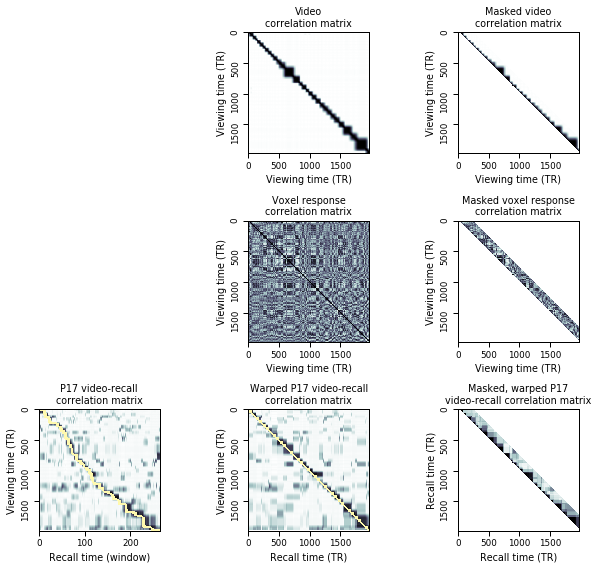

In [11]:
fig, (vid_ax, brain_ax, rec_ax) = plt.subplots(3, 3)
(v1, v2, v3), (b1, b2, b3), (r1, r2, r3) = vid_ax, brain_ax, rec_ax
fig.set_size_inches(9, 8)

v1.axis('off')

# video correlation matrix
v2 = sns.heatmap(vv_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=v2)
v2.set_xlabel('Viewing time (TR)')
v2.set_ylabel('Viewing time (TR)')
v2.set_title('Video\ncorrelation matrix')
for _, spine in v2.spines.items():
    spine.set_visible(True)
v2.collections[0].remove()
v2.imshow(vv_corrmat, aspect='equal', cmap=corrmat_cmap)

# masked video correlation matrix
v3 = sns.heatmap(vv_masked, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=v3)
v3.set_xlabel('Viewing time (TR)')
v3.set_ylabel('Viewing time (TR)')
v3.set_title('Masked video\ncorrelation matrix')
for _, spine in v3.spines.items():
    spine.set_visible(True)
v3.collections[0].remove()
v3.imshow(vv_masked, aspect='equal', cmap=corrmat_cmap)

b1.axis('off')

# voxel response correlation matrix
b2 = sns.heatmap(bb_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=-1, vmax=1, cbar=False, ax=b2)
b2.set_xlabel('Viewing time (TR)')
b2.set_ylabel('Viewing time (TR)')
b2.set_title('Voxel response\ncorrelation matrix')
for _, spine in b2.spines.items():
    spine.set_visible(True)
b2.collections[0].remove()
b2.imshow(bb_corrmat, aspect='equal', cmap=corrmat_cmap)

# masked voxel response correlation matrix
b3 = sns.heatmap(bb_masked, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=-1, vmax=1, cbar=False, ax=b3)
b3.set_xlabel('Viewing time (TR)')
b3.set_ylabel('Viewing time (TR)')
b3.set_title('Masked voxel response\ncorrelation matrix')
for _, spine in b3.spines.items():
    spine.set_visible(True)
b3.collections[0].remove()
b3.imshow(bb_masked, aspect='equal', cmap=corrmat_cmap)


# P17 video-recall correlation matrix
r1 = sns.heatmap(vr_corrmat, xticklabels=100, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=r1)
r1.set_xlabel('Recall time (window)')
r1.set_ylabel('Viewing time (TR)')
r1.set_title('P17 video-recall\ncorrelation matrix')
for _, spine in r1.spines.items():
    spine.set_visible(True)
r1.collections[0].remove()
r1.imshow(vr_corrmat, aspect=(vr_corrmat.shape[1] / vr_corrmat.shape[0]), cmap=corrmat_cmap)
for vid_ix, rec_ix in zip(vid_path, rec_path):
    pt = patches.Rectangle((rec_ix, vid_ix), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    r1.add_patch(pt)
    
# P17 warped video-recall correlation matrix
r2 = sns.heatmap(vr_dtw_corrmat, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=r2)
r2.set_xlabel('Recall time (TR)')
r2.set_ylabel('Viewing time (TR)')
r2.set_title('Warped P17 video-recall\ncorrelation matrix')
for _, spine in r2.spines.items():
    spine.set_visible(True)
r2.collections[0].remove()
r2.imshow(vr_dtw_corrmat, aspect='equal', cmap=corrmat_cmap)
for i in range(1976):
    pt = patches.Rectangle((i, i), 1, 1, linewidth=2, edgecolor='#FFF9AE', facecolor='#FFF9AE', zorder=2)
    r2.add_patch(pt)
    
# P17 masked warped recall-recall correlation matrix
r3 = sns.heatmap(rr_masked, xticklabels=500, yticklabels=500, cmap=corrmat_cmap, vmin=0, vmax=1, cbar=False, ax=r3)
r3.set_xlabel('Recall time (TR)')
r3.set_ylabel('Recall time (TR)')
r3.set_title('Masked, warped P17\nvideo-recall correlation matrix')
for _, spine in r3.spines.items():
    spine.set_visible(True)
r3.collections[0].remove()
r3.imshow(rr_masked, aspect='equal', cmap=corrmat_cmap)

plt.subplots_adjust(wspace=.45, hspace=.75)
plt.tight_layout()
# plt.savefig(opj(figdir, 'tmp', 'brain_corrmats.pdf'), dpi=1000)
plt.show()

## Plot searchlight maps

In [12]:
combined_surface_left = np.zeros_like(vid_surface_left)
combined_surface_right = np.zeros_like(vid_surface_right)

combined_surface_left[vid_surface_left != 0] = 1
combined_surface_right[vid_surface_right != 0] = 1
combined_surface_left[rec_surface_left != 0] = 2
combined_surface_right[rec_surface_right != 0] = 2
combined_surface_left[(vid_surface_left != 0) & (rec_surface_left != 0)] = 3
combined_surface_right[(vid_surface_right != 0) & (rec_surface_right != 0)] = 3

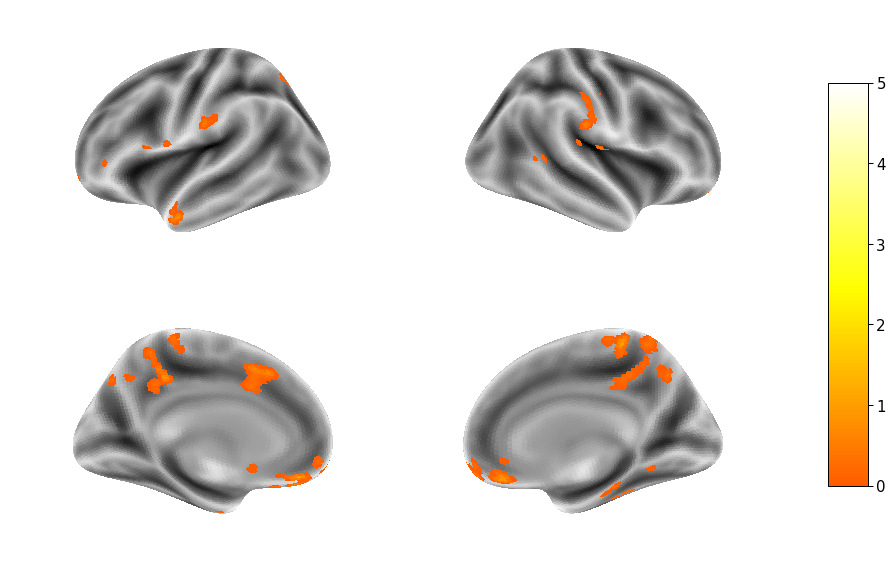

In [13]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(11, 8), subplot_kw={'projection': '3d'})

plot_surf_stat_map(fsaverage.infl_left, vid_surface_left, hemi='left', view='lateral', 
                   bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=a, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, vid_surface_right, hemi='right', view='lateral', 
                   bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=b, colorbar=False)

plot_surf_stat_map(fsaverage.infl_left, vid_surface_left, hemi='left', view='medial', 
                   bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=c, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, vid_surface_right, hemi='right', view='medial', 
                   bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=d, colorbar=False)

plt.subplots_adjust()
plt.tight_layout()
cbar_ax = fig.add_axes([1.05, .15, .05, .7])
draw_colorbar(cbar_ax, cmap=brain_cmap, vmin=0, vmax=5, tick_freq=1., ticklocation='right', ticklabel_size=15)
# plt.savefig(opj(figdir, 'tmp', 'searchlight_video.pdf'), bbox_inches='tight')
plt.show()

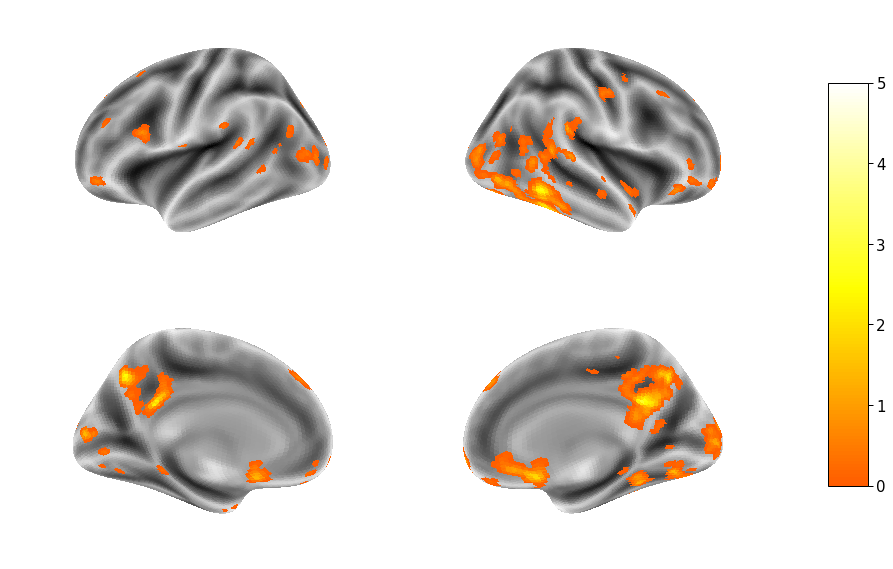

In [14]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(11, 8), subplot_kw={'projection': '3d'})

plot_surf_stat_map(fsaverage.infl_left, rec_surface_left, hemi='left', view='lateral', 
                   bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=a, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, rec_surface_right, hemi='right', view='lateral', 
                   bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=b, colorbar=False)

plot_surf_stat_map(fsaverage.infl_left, rec_surface_left, hemi='left', view='medial', 
                   bg_map=fsaverage.sulc_left, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=c, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, rec_surface_right, hemi='right', view='medial', 
                   bg_map=fsaverage.sulc_right, cmap=brain_cmap, threshold=.01, 
                   vmax=5, axes=d, colorbar=False)

plt.subplots_adjust()
plt.tight_layout()
cbar_ax = fig.add_axes([1.05, .15, .05, .7])
draw_colorbar(cbar_ax, cmap=brain_cmap, vmin=0, vmax=5, tick_freq=1., ticklocation='right', ticklabel_size=15)
# plt.savefig(opj(figdir, 'tmp', 'searchlight_recall.pdf'), bbox_inches='tight')
plt.show()

## Plot p-value maps 

In [15]:
ns_vid_pr = vol_to_surf(ns_vmap, fsaverage.pial_right)
ns_vid_pl = vol_to_surf(ns_vmap, fsaverage.pial_left)
ns_rec_pr = vol_to_surf(ns_rmap, fsaverage.pial_right)
ns_rec_pl = vol_to_surf(ns_rmap, fsaverage.pial_left)

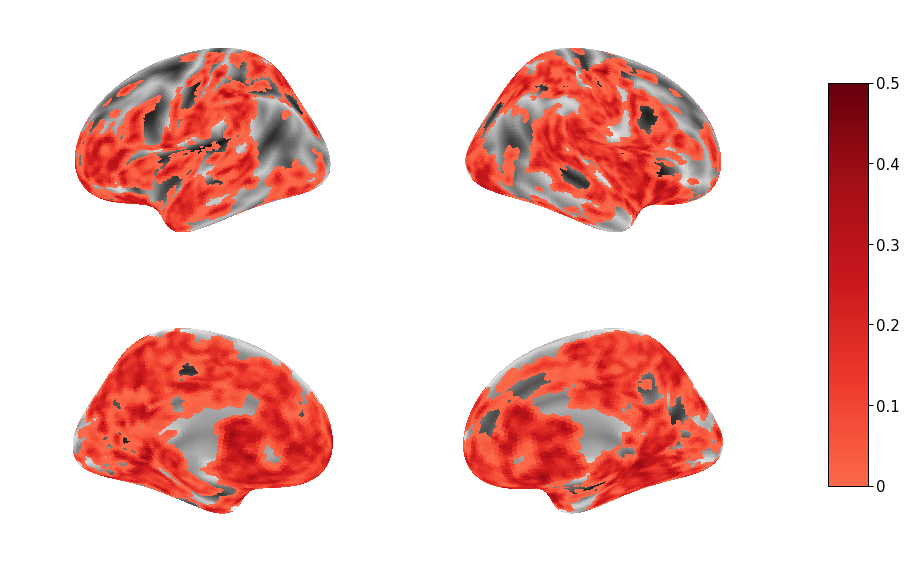

In [16]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(11, 8), subplot_kw={'projection': '3d'})

plot_surf_stat_map(fsaverage.infl_left, ns_vid_pl, hemi='left', view='lateral', 
                   bg_map=fsaverage.sulc_left, cmap=plt.cm.Reds, threshold=1e-5, 
                   vmax=.5, axes=a, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, ns_vid_pr, hemi='right', view='lateral', 
                   bg_map=fsaverage.sulc_right, cmap=plt.cm.Reds, threshold=1e-5, 
                   vmax=.5, axes=b, colorbar=False)

plot_surf_stat_map(fsaverage.infl_left, ns_vid_pl, hemi='left', view='medial', 
                   bg_map=fsaverage.sulc_left, cmap=plt.cm.Reds, threshold=1e-5, 
                   vmax=.5, axes=c, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, ns_vid_pr, hemi='right', view='medial', 
                   bg_map=fsaverage.sulc_right, cmap=plt.cm.Reds, threshold=1e-5, 
                   vmax=.5, axes=d, colorbar=False)

plt.subplots_adjust()
plt.tight_layout()
cbar_ax = fig.add_axes([1.05, .15, .05, .7])
draw_colorbar(cbar_ax, cmap=plt.cm.Reds, vmin=0, vmax=.5, tick_freq=.1, ticklocation='right', ticklabel_size=15)
# plt.savefig(opj(figdir, 'tmp', 'neurosynth_vmap.pdf'), bbox_inches='tight')
plt.show()

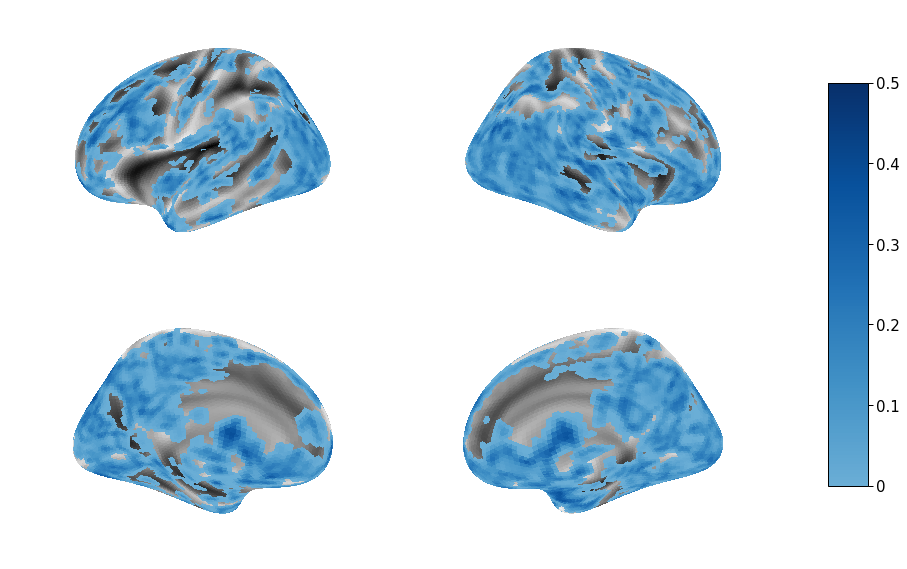

In [17]:
fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(11, 8), subplot_kw={'projection': '3d'})

plot_surf_stat_map(fsaverage.infl_left, ns_rec_pl, hemi='left', view='lateral', 
                   bg_map=fsaverage.sulc_left, cmap=plt.cm.Blues, threshold=1e-5, 
                   vmax=.5, axes=a, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, ns_rec_pr, hemi='right', view='lateral', 
                   bg_map=fsaverage.sulc_right, cmap=plt.cm.Blues, threshold=1e-5, 
                   vmax=.5, axes=b, colorbar=False)

plot_surf_stat_map(fsaverage.infl_left, ns_rec_pl, hemi='left', view='medial', 
                   bg_map=fsaverage.sulc_left, cmap=plt.cm.Blues, threshold=1e-5, 
                   vmax=.5, axes=c, colorbar=False)

plot_surf_stat_map(fsaverage.infl_right, ns_rec_pr, hemi='right', view='medial', 
                   bg_map=fsaverage.sulc_right, cmap=plt.cm.Blues, threshold=1e-5, 
                   vmax=.5, axes=d, colorbar=False)

plt.subplots_adjust()
plt.tight_layout()
cbar_ax = fig.add_axes([1.05, .15, .05, .7])
draw_colorbar(cbar_ax, cmap=plt.cm.Blues, vmin=0, vmax=.5, tick_freq=.1, ticklocation='right', ticklabel_size=15)
# plt.savefig(opj(figdir, 'tmp', 'neurosynth_rmap.pdf'), bbox_inches='tight')
plt.show()